# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [93]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

In [67]:
IMG_SIZE = (224, 224)  # размер входного изображения сети
IMG_SIZE_INS = (229, 229)  # размер входного изображения сети

## Функции загрузки данных

In [71]:
import re
from random import shuffle
from glob import glob

train_files = glob('./data/train/*.jpg')
test_files = glob('./data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16
# загружаем входное изображение и предобрабатываем
def load_image_ins(path, target_size=IMG_SIZE_INS):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16
# генератор для последовательного чтения обучающих данных с диска
def fit_generator_ins(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image_ins(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*dog\.\d+.*', path) else 0. for path in files[i:j]])
            yield (x, y)
# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*dog\.\d+.*', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])
def predict_generator_ins(files):
    while True:
        for path in files:
            yield np.array([load_image_ins(path)])

## Визуализируем примеры для обучения

25000


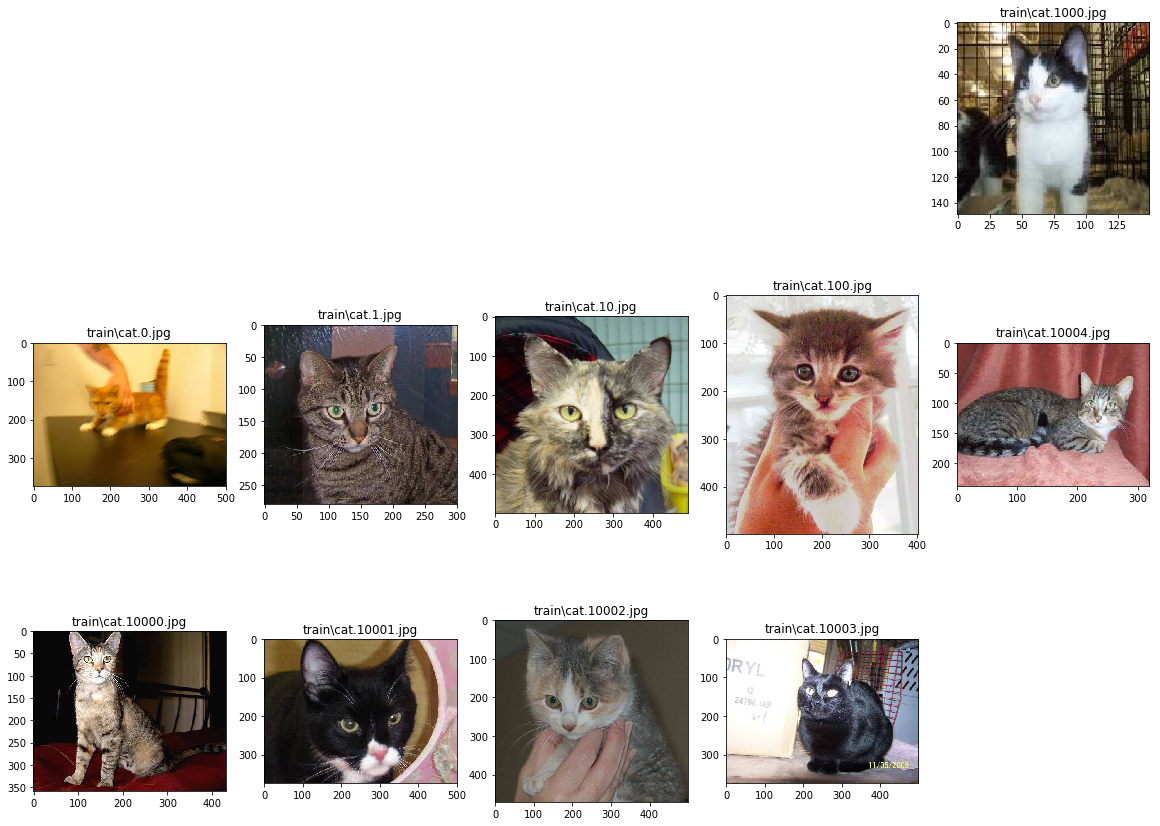

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [26]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [27]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

## Добавляем полносвязный слой

In [50]:
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1000, 
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l1(1e-4))(x)
x = keras.layers.Dense(1,  # один выход
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Компилируем модель и запускаем обучение

In [51]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [63]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
                    steps_per_epoch=10,  # число вызовов генератора за эпоху
                    epochs=20,  # число эпох обучения
                    validation_data=validation_data)

Epoch 1/20
10/10 [==============================] - 175s - loss: 0.4131 - acc: 0.9688 - val_loss: 0.4010 - val_acc: 0.9600
Epoch 2/20
10/10 [==============================] - 175s - loss: 0.4386 - acc: 0.9812 - val_loss: 0.3967 - val_acc: 0.9700
Epoch 3/20
10/10 [==============================] - 174s - loss: 0.4148 - acc: 0.9688 - val_loss: 0.3931 - val_acc: 0.9700
Epoch 4/20
10/10 [==============================] - 175s - loss: 0.4276 - acc: 0.9719 - val_loss: 0.3868 - val_acc: 0.9700
Epoch 5/20
10/10 [==============================] - 173s - loss: 0.4174 - acc: 0.9812 - val_loss: 0.3875 - val_acc: 0.9700
Epoch 6/20
10/10 [==============================] - 174s - loss: 0.4060 - acc: 0.9688 - val_loss: 0.3993 - val_acc: 0.9600
Epoch 7/20
10/10 [==============================] - 172s - loss: 0.4131 - acc: 0.9719 - val_loss: 0.3872 - val_acc: 0.9600
Epoch 8/20
10/10 [==============================] - 173s - loss: 0.3988 - acc: 0.9719 - val_loss: 0.3825 - val_acc: 0.9600
Epoch 9/20
10/10

## Предсказания на проверочной выборке

In [64]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

In [61]:
predst= np.clip(pred,0.0125,0.9875) 

In [87]:
# base_model -  объект класса keras.models.Model (Functional Model)
from keras.applications.inception_v3 import InceptionV3
ins_model = InceptionV3(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE_INS[0], IMG_SIZE_INS[1], 3))
for layer in ins_model.layers:
    layer.trainable = False
x = ins_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(10,  # один выход
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l1(1e-4))(x)
x = keras.layers.Dense(1,  # один выход
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model_ins = Model(inputs=ins_model.input, outputs=x)
model_ins.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [89]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator_ins(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model_ins.fit_generator(fit_generator_ins(train_files[train_val_split:]),  # данные читаем функцией-генератором
                    steps_per_epoch=10,  # число вызовов генератора за эпоху
                    epochs=50,  # число эпох обучения
                    validation_data=validation_data)

Epoch 1/50
10/10 [==============================] - 61s - loss: 0.5444 - acc: 0.9281 - val_loss: 0.4962 - val_acc: 0.9600
Epoch 2/50
10/10 [==============================] - 61s - loss: 0.5494 - acc: 0.9094 - val_loss: 0.4909 - val_acc: 0.9400
Epoch 3/50
10/10 [==============================] - 61s - loss: 0.5144 - acc: 0.9281 - val_loss: 0.5024 - val_acc: 0.9400
Epoch 4/50
10/10 [==============================] - 61s - loss: 0.5112 - acc: 0.9156 - val_loss: 0.4961 - val_acc: 0.9400
Epoch 5/50
10/10 [==============================] - 60s - loss: 0.5754 - acc: 0.9031 - val_loss: 0.5332 - val_acc: 0.9200
Epoch 6/50
10/10 [==============================] - 61s - loss: 0.5332 - acc: 0.9219 - val_loss: 0.4975 - val_acc: 0.9500
Epoch 7/50
10/10 [==============================] - 62s - loss: 0.5246 - acc: 0.9187 - val_loss: 0.5006 - val_acc: 0.9600
Epoch 8/50
10/10 [==============================] - 61s - loss: 0.5285 - acc: 0.9219 - val_loss: 0.4957 - val_acc: 0.9400
Epoch 9/50
10/10 [======

In [90]:
import time
prev = time.time()
pred = model_ins.predict_generator(predict_generator_ins(test_files), len(test_files), max_queue_size=500)
print(time.time() - prev)

1997.553921699524


In [44]:
import time
prev = time.time()
pred = model.predict_generator(predict_generator(test_files[:100]), 100, max_queue_size=500)
print(time.time() - prev)

41.66260051727295


## VGG19

In [97]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model_vgg19 = VGG19(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))
# фиксируем все веса предобученной сети
for layer in base_model_vgg19.layers[:-5]:
    layer.trainable = False
    
x = base_model_vgg19.output
x = keras.layers.Flatten()(x)
#x = keras.layers.Dense(1024, activation="relu")(x)
#x = keras.layers.Dropout(0.5)(x)
#x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dense(1,  # один выход
                       activation='sigmoid'  # функция активации  
                      #, kernel_regularizer=keras.regularizers.l1(1e-4)
                      )(x)
model_vgg19 = Model(inputs=base_model_vgg19.input, outputs=x)
model_vgg19.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [ ]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model_vgg19.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
                    steps_per_epoch=10,  # число вызовов генератора за эпоху
                    epochs=50,  # число эпох обучения
                    validation_data=validation_data)

Epoch 1/50
10/10 [==============================] - 201s - loss: 7.1115 - acc: 0.5344 - val_loss: 8.2900 - val_acc: 0.4800
Epoch 2/50
10/10 [==============================] - 202s - loss: 8.4694 - acc: 0.4688 - val_loss: 8.2900 - val_acc: 0.4800
Epoch 3/50
10/10 [==============================] - 204s - loss: 7.8716 - acc: 0.5062 - val_loss: 8.2900 - val_acc: 0.4800
Epoch 4/50
10/10 [==============================] - 204s - loss: 7.7719 - acc: 0.5125 - val_loss: 8.2900 - val_acc: 0.4800
Epoch 5/50
10/10 [==============================] - 204s - loss: 8.3698 - acc: 0.4750 - val_loss: 8.2900 - val_acc: 0.4800
Epoch 6/50
 9/10 [==========================>...] - ETA: 16s - loss: 7.8051 - acc: 0.5104

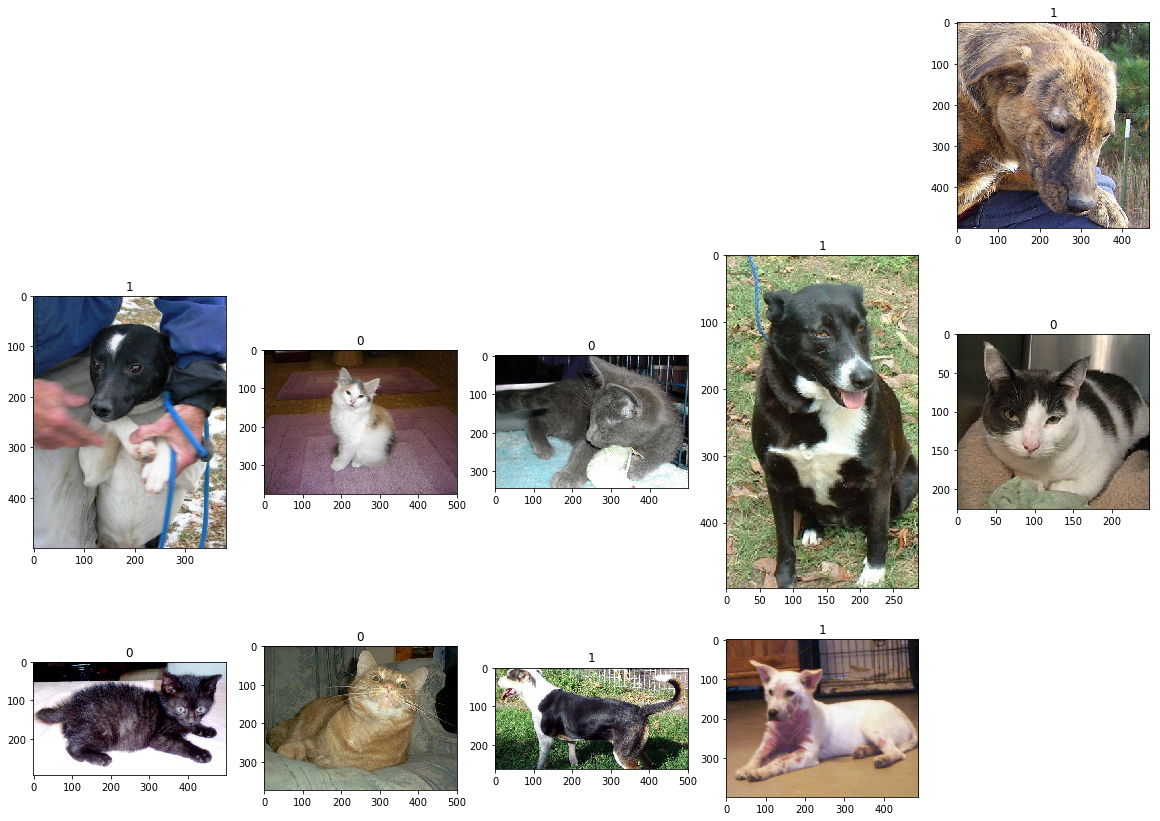

In [91]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[:10], pred[:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.d' % int(score > 0.5));

## Готовим данные для сабмита

In [92]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [49]:
# LogLoss = 1.04979